In [1]:
# Importing required library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.offline as po
po.init_notebook_mode(connected=True)
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from pylab import rcParams
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
"""Loading the data"""
data = pd.read_csv("household_power_consumption.txt",  delimiter=';', low_memory=False)

In [3]:
data.head(20)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
5,16/12/2006,17:29:00,3.520,0.522,235.020,15.000,0.000,2.000,17.0
6,16/12/2006,17:30:00,3.702,0.520,235.090,15.800,0.000,1.000,17.0
7,16/12/2006,17:31:00,3.700,0.520,235.220,15.800,0.000,1.000,17.0
8,16/12/2006,17:32:00,3.668,0.510,233.990,15.800,0.000,1.000,17.0
9,16/12/2006,17:33:00,3.662,0.510,233.860,15.800,0.000,2.000,16.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


### Preprocessing the data

In [5]:
# Convert 'Date' to datetime and 'Time' to time
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data['Time'] = pd.to_datetime(data['Time'], format='%H:%M:%S').dt.time

# Combine 'Date' and 'Time' into a single datetime column
data['Datetime'] = pd.to_datetime(data['Date'].astype(str) + ' ' + data['Time'].astype(str))

# Set 'Datetime' as the index
data.set_index('Datetime', inplace=True)



In [6]:
data.fillna(method='ffill', inplace=True)

In [7]:
data.isnull().sum()

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [8]:
data.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,,,
2006-12-16 17:24:00,2006-12-16,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,2006-12-16,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,2006-12-16,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,2006-12-16,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,2006-12-16,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [9]:
data = data.drop(columns=['Date', 'Time'])

In [10]:
data

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.430,4.000,0.000,0.000,0.0
2010-11-26 20:59:00,0.944,0.000,240.000,4.000,0.000,0.000,0.0
2010-11-26 21:00:00,0.938,0.000,239.820,3.800,0.000,0.000,0.0


In [15]:
# Convert other columns to numeric, forcing errors to NaN
cols = data.columns
data[cols] = data[cols].apply(pd.to_numeric, errors='coerce')

In [16]:
data = data.resample('H').sum()


In [17]:
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:00:00,152.024,8.244,8447.18,651.6,0.0,19.0,607.0
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0,1012.0
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0,1001.0
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0,1007.0
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0,1033.0


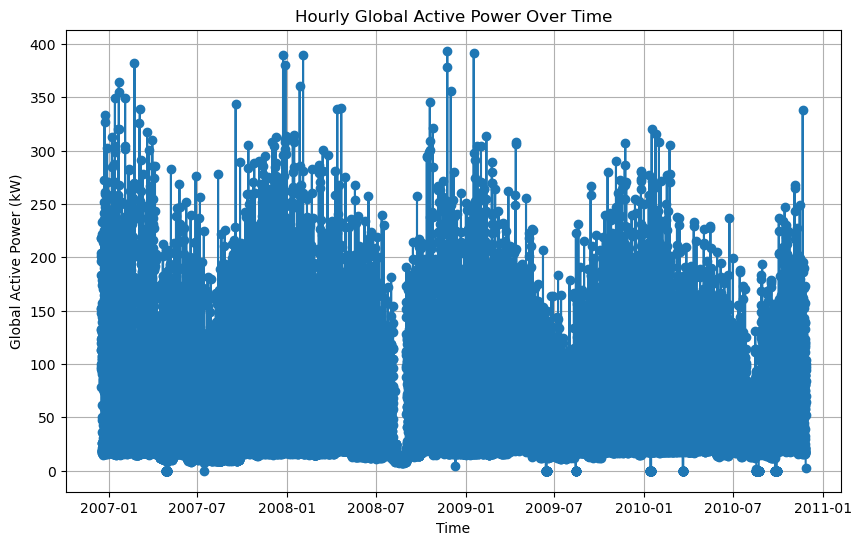

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(data.index, data2['Global_active_power'], marker='o')
plt.title('Hourly Global Active Power Over Time')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.grid(True)
plt.show()


In [19]:
data.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [20]:

from scipy.stats import pearsonr

# Apply the pearsonr()
corr, _ = pearsonr(data['Global_active_power'], data['Voltage'])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.091


In [21]:
data['Global_active_power'].corr(data['Voltage'], method="pearson")

0.0909015045682944

In [22]:
data['Voltage'].corr(data['Global_intensity'], method="pearson")

0.09107970861880942

In [ ]:
#Resample data to hourly

##hourly_data = data.resample('H').mean()
#hourly_data.head()


In [ ]:
#import matplotlib.pyplot as plt

#plt.figure(figsize=(10, 6))
#plt.plot(hourly_data.index, hourly_data['Global_active_power'], marker='o')
#plt.title('Hourly Global Active Power Over Time')
#plt.xlabel('dt')
#plt.ylabel('Global Active Power (kW)')
#plt.grid(True)
#plt.show()


In [ ]:
# Convert other columns to numeric, forcing errors to NaN
#cols = data.columns.drop(['Date', 'Time'])
#data[cols] = data[cols].apply(pd.to_numeric, errors='coerce')

# Drop rows with any NaN values
#data.dropna(inplace=True)




In [ ]:
# Display cleaned data
data.head()

In [ ]:
# Convert the 'Date' and 'Time' columns to a single 'date_time' column by combining the two columns and converting to datetime format
#data['date_time'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])

In [ ]:
data.isnull().sum()

In [ ]:
data.shape

In [ ]:
# Convert the 'Global_active_power' column to numeric format and remove any rows with NaN values
#data['Global_active_power'] = pd.to_numeric(data['Global_active_power'], errors='coerce')
#data = data.dropna(subset=['Global_active_power'])

### Visualizing the data

In [ ]:
# Plotting time series data for Global_active_power
plt.figure(figsize=(15, 5))
plt.plot(data.index, data['Global_active_power'], label='Global Active Power')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power (kilowatts)')
plt.title('Global Active Power over Time')
plt.legend()
plt.show()

# Histogram of Global_active_power
plt.figure(figsize=(10, 5))
data['Global_active_power'].hist(bins=50)
plt.xlabel('Global Active Power (kilowatts)')
plt.ylabel('Frequency')
plt.title('Histogram of Global Active Power')
plt.show()

# Box plot of Voltage
plt.figure(figsize=(10, 5))
data.boxplot(column='Voltage')
plt.title('Box Plot of Voltage')
plt.show()

### Decompose the data

In [ ]:
# Step 3: Decompose the data
result = seasonal_decompose(data['Global_active_power'], model='additive', period=60)  # Assuming daily pattern (1440 minutes in a day)

# Plot the decomposed components
result.plot()
plt.show()

### Testing for stationarity

22:17:51 - cmdstanpy - INFO - Chain [1] start processing
22:17:52 - cmdstanpy - INFO - Chain [1] done processing


             ds         yhat   yhat_lower   yhat_upper
1437 2010-11-22  1858.778168  1317.813240  2435.004868
1438 2010-11-23  2004.066199  1444.878282  2584.631835
1439 2010-11-24  2000.093630  1455.079097  2566.106204
1440 2010-11-25  1834.661747  1279.522900  2412.930619
1441 2010-11-26  1949.890511  1397.593082  2542.472313


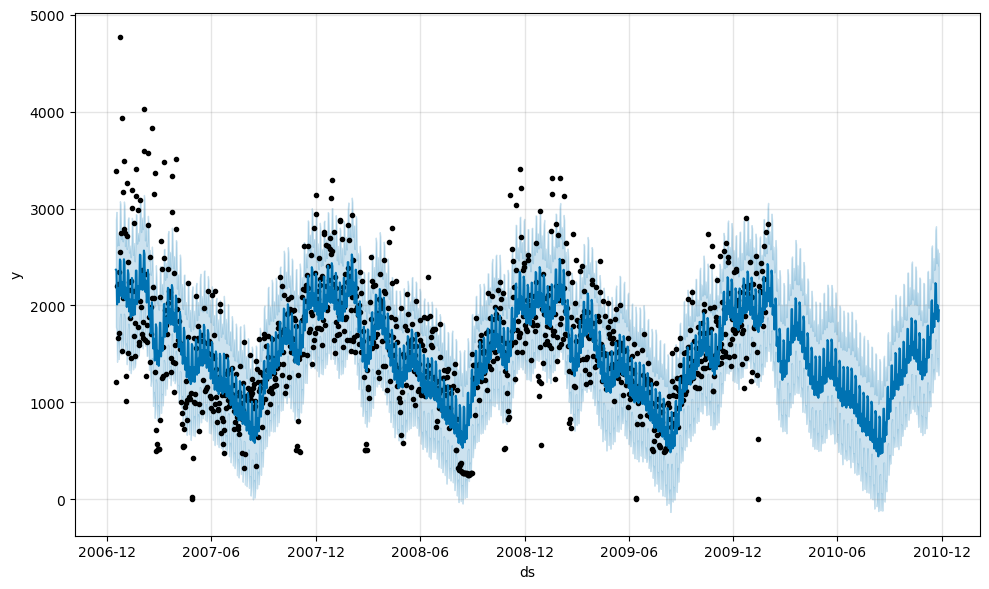

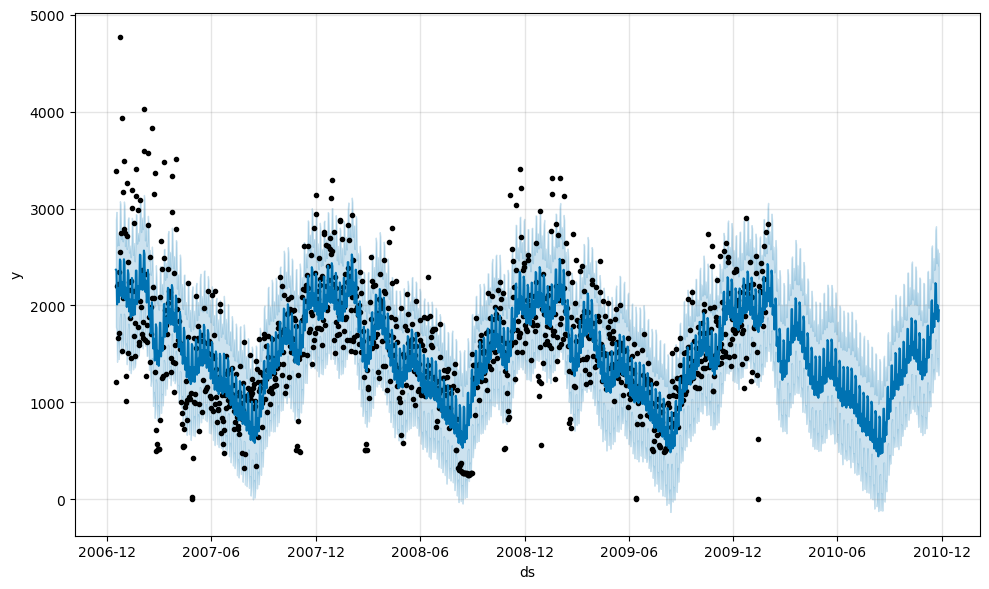

In [24]:


# Step 2: Resample the data to daily frequency, summing the 'Global_active_power'
daily_data = data['Global_active_power'].resample('D').sum().reset_index()

# Rename columns to 'ds' and 'y' for Prophet
daily_data.rename(columns={'Datetime': 'ds', 'Global_active_power': 'y'}, inplace=True)

# Step 3: Split the data into training and test sets
x = len(daily_data)
train = daily_data.iloc[:x-300]
test = daily_data.iloc[x-300:]

# Step 4: Train a univariate time series model using Facebook Prophet
model = Prophet()
model.fit(train)

# Step 5: Make predictions
future = model.make_future_dataframe(periods=300)
forecast = model.predict(future)

# Display the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Plot the forecast
model.plot(forecast)

In [25]:

daily_data2 = data.resample('D').sum().reset_index()

# Step 3: Rename columns appropriately for Prophet
daily_data2.rename(columns={'Datetime': 'ds', 'Global_active_power': 'y', 
                           'Global_reactive_power': 'add1', 'Voltage': 'add2', 
                           'Global_intensity': 'add3', 'Sub_metering_1': 'add4', 
                           'Sub_metering_2': 'add5', 'Sub_metering_3': 'add6'}, inplace=True)

# Step 4: Split the data into training and test sets
x = len(daily_data2)
train = daily_data2.iloc[:x-300]
test = daily_data2.iloc[x-300:]

# Step 5: Initialize and fit the Prophet model with regressors
model = Prophet()
regressors = ['add1', 'add2', 'add3', 'add4', 'add5', 'add6']
for regressor in regressors:
    model.add_regressor(regressor)

model.fit(train)

# Step 6: Make future dataframe and predict
future = model.make_future_dataframe(periods=300)
for regressor in regressors:
    future[regressor] = daily_data[regressor]

forecast = model.predict(future)

# Step 7: Display the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Plot the forecast
model.plot(forecast)

# Optional: Plot the components
model.plot_components(forecast)

22:18:02 - cmdstanpy - INFO - Chain [1] start processing
22:18:03 - cmdstanpy - INFO - Chain [1] done processing


KeyError: 'add1'

In [ ]:
daily_data.head()

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming 'y_true' are the actual values and 'y_pred' are the predicted values
y_true = test['y'].values
y_pred = forecast['yhat'].iloc[-300:].values

# Calculate MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')

# Calculate MSE
mse = mean_squared_error(y_true, y_pred)
print(f'MSE: {mse}')

# Calculate RMSE
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')